In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score
from statsmodels.tsa.ar_model import ar_select_order, AutoReg

import seaborn as sns
# Set figure size to (14,6)

plt.rcParams['figure.figsize'] = (12,5)
sns.set_theme(style='whitegrid')


# 7.3. Evaluating Forecasts


## 1. Recap on our modeling on train data

In [2]:
# custom plot function

def plot_timeseries(df, title="", ylim=True):
    """
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    
    """
    
    df.plot(linestyle='-', marker='.')
    plt.title(title)
    if ylim:
        plt.ylim(ymin=0)
    plt.ylabel("Passengers in 1000s")
    plt.show()

In [3]:
flights_train = pd.read_csv("flights_train.csv", parse_dates=True, index_col='date')
flights_train.head()

,passengers
date,
1949-01-01,64
1949-02-01,75
1949-03-01,98
1949-04-01,93
1949-05-01,80


In [4]:
flights_train['timestep'] = list(range(flights_train.shape[0]))
# add timestep feature = trend
flights_train.head()

,passengers,timestep
date,,
1949-01-01,64,0
1949-02-01,75,1
1949-03-01,98,2
1949-04-01,93,3
1949-05-01,80,4


In [5]:


# add month feature and convert to hot-one encoding 
flights_train['month'] = flights_train.index.month_name()

In [6]:
flights_train.head()

,passengers,timestep,month
date,,,
1949-01-01,64,0,January
1949-02-01,75,1,February
1949-03-01,98,2,March
1949-04-01,93,3,April
1949-05-01,80,4,May


In [7]:

flights_train = pd.get_dummies(flights_train, prefix='', prefix_sep='')

flights_train.head()

,passengers,timestep,April,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,
1949-01-01,64,0,0,0,0,0,1,0,0,0,0,0,0,0
1949-02-01,75,1,0,0,0,1,0,0,0,0,0,0,0,0
1949-03-01,98,2,0,0,0,0,0,0,0,1,0,0,0,0
1949-04-01,93,3,1,0,0,0,0,0,0,0,0,0,0,0
1949-05-01,80,4,0,0,0,0,0,0,0,0,1,0,0,0


In [8]:
# define features and targets, instantiate model

X = flights_train.drop('passengers', axis=1)
y = flights_train['passengers']

m_trend_seasonal = LinearRegression()


In [10]:
# train model and add predictions as a column trend_seasonal

m_trend_seasonal.fit(X, y)

flights_train['trend_seasonal'] = m_trend_seasonal.predict(X)


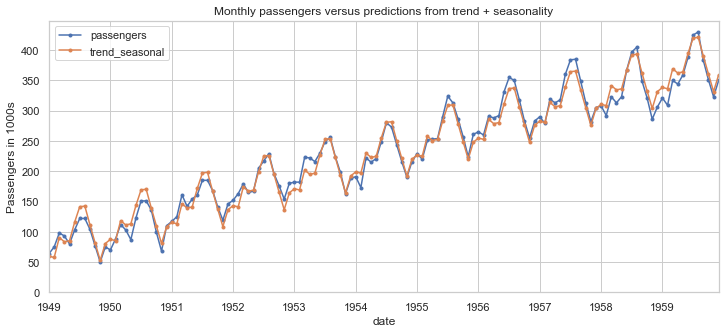

In [11]:
plot_timeseries(flights_train[['passengers', 'trend_seasonal']], 
                title="Monthly passengers versus predictions from trend + seasonality")


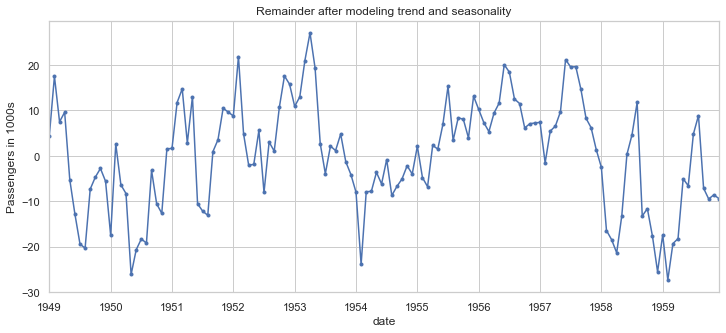

In [12]:
# extract remainder as a feature
flights_train['remainder'] = flights_train['passengers'] - flights_train['trend_seasonal']
# plot remainder 
plot_timeseries(flights_train['remainder'], title="Remainder after modeling trend and seasonality", ylim=False)

## 2. Calculate and add our lag feauture to the train data

In [13]:
# since remainder appears to be a stationary time series with values at different time instants that seem correlated 
# we introduced a lag feature of the remainder

# we add it now to our model because we want better predictions for the main target passengers

flights_train['lag1'] = flights_train['remainder'].shift(1)



In [14]:
# drop na

flights_train.dropna(inplace=True)


## 3. Train the full linear auto-regression model on the training data

In [15]:
# define our new X and y and instantiate model

X = flights_train.drop(['passengers', 'trend_seasonal', 'remainder'], axis=1)
y = flights_train['passengers']

m_full = LinearRegression()

m_full.fit(X,y)



LinearRegression()

In [16]:
flights_train['predictions_full'] = m_full.predict(X)

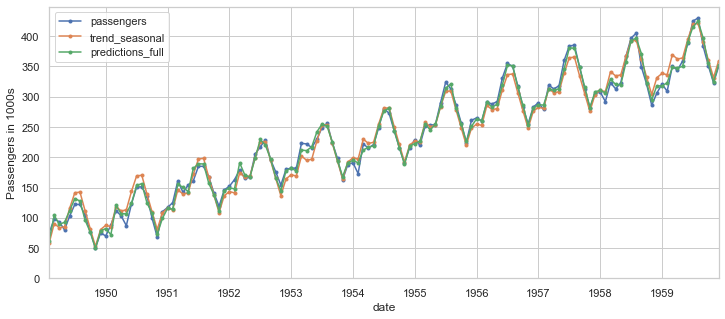

In [17]:
# plot target and predictions

plot_timeseries(flights_train[['passengers', 'trend_seasonal', 'predictions_full']])

In [18]:
# extracting full model coefficients after the training 

pd.DataFrame(m_full.coef_.reshape(1,14), columns=X.columns)

,timestep,April,August,December,February,January,July,June,March,May,November,October,September,lag1
0,2.322448,-2.529887,47.08941,-23.927656,-23.794082,-20.530444,48.502768,25.188852,6.88347,-3.034154,-49.423389,-18.19185,13.766962,0.760241


### Is this model good?

----
----
----

## 4. Evaluate your model

We want to understand how good our model would work on data it has not been trained on. We can get an estimate of that by using cross-validation.

Cross-validation so far:

- Dividing training data into subsets (folds)
- in each iteration singled out one fold as validation set
- trained on the remaining training data and evaluated the fit on the validation set.
- order of the data is not important (we can shuffle the training data if we want)

Cross-validation for [time series](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

- Dividing training data into subsets (folds) - order respective to time is maintained
- in the first iteration, use the first fold to evaluate the second fold
- in the second iteration, use the first and thesecond fold to evaluate the third fold
- ...

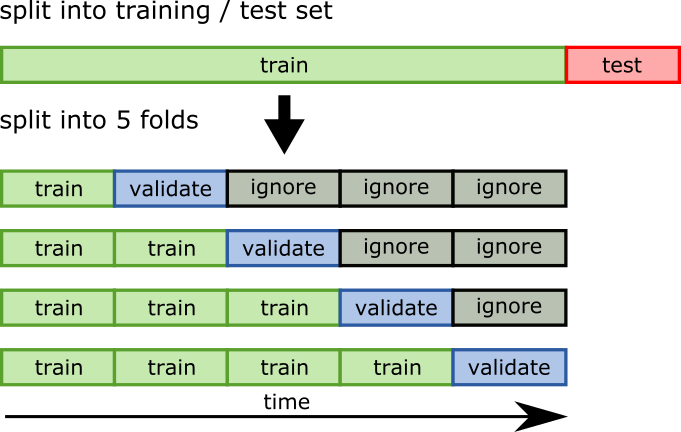

In [19]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5) # instanciate the class and give the k as input

time_cv = ts_split.split(X, y) # this is a python generator

In [20]:
# let's see how that works

# Split the training data into folds

for i, (train_index, validation_index) in enumerate(time_cv):
    print("The training data for iteration #{} are the observations steps  = {}".format(i+1, train_index))
    print("size of training data = {}".format(len(train_index)))
    print("The validation data for iteration #{} are the observations steps = {}".format(i+1, validation_index))
    print("size of validation data = {}".format(len(validation_index)))
    

The training data for iteration #1 are the observations steps  = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
size of training data = 26
The validation data for iteration #1 are the observations steps = [26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
size of validation data = 21
The training data for iteration #2 are the observations steps  = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
size of training data = 47
The validation data for iteration #2 are the observations steps = [47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
size of validation data = 21
The training data for iteration #3 are the observations steps  = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67

In [21]:
# cross validate model and read scores 
time_cv = ts_split.split(X, y)

estimator = LinearRegression() # instanciate 

r_squared_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=time_cv )

print(r_squared_scores)
print(r_squared_scores.mean())

[0.82727944 0.82914029 0.95730085 0.9419188  0.92308191]
0.8957442586519624


## 5. Apply our trained model on test data

##### -  Apply the same steps on the test data.


In [26]:
flights_test = pd.read_csv("flights_test.csv", parse_dates=True, index_col=0)

flights_test.head(3)


,passengers
date,
1960-01-01,357
1960-02-01,341
1960-03-01,358


##### - The column order must be identical

### 5.1 Add time step to test data

In [27]:
# get the last timestep of the training data
last_train_timestep = flights_train['timestep'][-1] 
last_train_timestep

131

In [28]:
flights_test['timestep'] = list(range(132,last_train_timestep + 1 + len(flights_test)))


### 5.2 Now let's create the dummies for the seasonal component of the test.

In [29]:
flights_test.index.month_name()

Index(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype='object', name='date')

In [30]:

flights_test['month'] = flights_test.index.month_name()

flights_test = pd.get_dummies(flights_test, prefix='', prefix_sep='')

flights_test.head()

,passengers,timestep,April,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,1,0,0,0,0,0,0,0
1960-02-01,341,133,0,0,0,1,0,0,0,0,0,0,0,0
1960-03-01,358,134,0,0,0,0,0,0,0,1,0,0,0,0
1960-04-01,382,135,1,0,0,0,0,0,0,0,0,0,0,0
1960-05-01,388,136,0,0,0,0,0,0,0,0,1,0,0,0


### 5.3 Add trend and seasonality prediction

In [31]:
X_test = flights_test.drop('passengers', axis=1)

X_test

,timestep,April,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,
1960-01-01,132,0,0,0,0,1,0,0,0,0,0,0,0
1960-02-01,133,0,0,0,1,0,0,0,0,0,0,0,0
1960-03-01,134,0,0,0,0,0,0,0,1,0,0,0,0
1960-04-01,135,1,0,0,0,0,0,0,0,0,0,0,0
1960-05-01,136,0,0,0,0,0,0,0,0,1,0,0,0
1960-06-01,137,0,0,0,0,0,0,1,0,0,0,0,0
1960-07-01,138,0,0,0,0,0,1,0,0,0,0,0,0
1960-08-01,139,0,1,0,0,0,0,0,0,0,0,0,0
1960-09-01,140,0,0,0,0,0,0,0,0,0,0,0,1


In [32]:

flights_test['trend_seasonal'] = m_trend_seasonal.predict(X_test)

flights_test.head()

,passengers,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal
date,,,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,1,0,0,0,0,0,0,0,366.286364
1960-02-01,341,133,0,0,0,1,0,0,0,0,0,0,0,0,364.195455
1960-03-01,358,134,0,0,0,0,0,0,0,1,0,0,0,0,397.195455
1960-04-01,382,135,1,0,0,0,0,0,0,0,0,0,0,0,390.104545
1960-05-01,388,136,0,0,0,0,0,0,0,0,1,0,0,0,391.922727


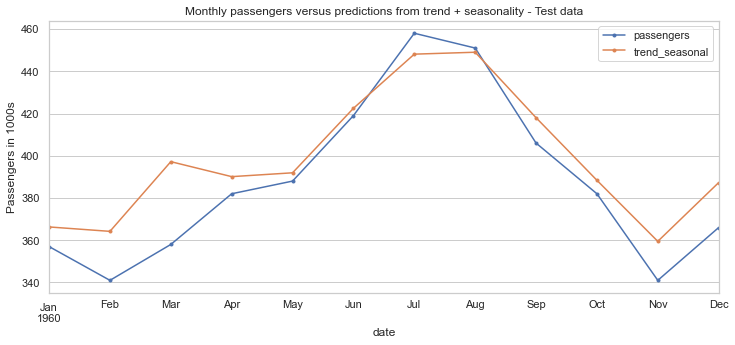

In [33]:
# plot

plot_timeseries(flights_test[['passengers', 'trend_seasonal']], ylim=False,
                title="Monthly passengers versus predictions from trend + seasonality - Test data")


### 5.4 Calculate remainder and add lag1

In [34]:
flights_test['remainder'] = flights_test['passengers'] - flights_test['trend_seasonal']
# Calculate the reminder as our additional feature of AR model


In [35]:
# Create the lagged variable
flights_test['lag1'] = flights_test['remainder'].shift(1)



### 5.5 Use trained full model to predict passengers

In [36]:
# Fill the missing value from the beginning of the test set.

flights_test.loc['1960-01-01', 'lag1'] = flights_train.loc['1959-12-01', 'remainder']

flights_test

,passengers,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1
date,,,,,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,1,0,0,0,0,0,0,0,366.286364,-9.286364,-9.405303
1960-02-01,341,133,0,0,0,1,0,0,0,0,0,0,0,0,364.195455,-23.195455,-9.286364
1960-03-01,358,134,0,0,0,0,0,0,0,1,0,0,0,0,397.195455,-39.195455,-23.195455
1960-04-01,382,135,1,0,0,0,0,0,0,0,0,0,0,0,390.104545,-8.104545,-39.195455
1960-05-01,388,136,0,0,0,0,0,0,0,0,1,0,0,0,391.922727,-3.922727,-8.104545
1960-06-01,419,137,0,0,0,0,0,0,1,0,0,0,0,0,422.468182,-3.468182,-3.922727
1960-07-01,458,138,0,0,0,0,0,1,0,0,0,0,0,0,448.104545,9.895455,-3.468182
1960-08-01,451,139,0,1,0,0,0,0,0,0,0,0,0,0,449.013636,1.986364,9.895455
1960-09-01,406,140,0,0,0,0,0,0,0,0,0,0,0,1,418.013636,-12.013636,1.986364


In [37]:
# make full model predictions

X_test = flights_test.drop(['passengers', 'trend_seasonal', 'remainder'], axis=1)

# Create the predictions
flights_test['predictions_full'] = m_full.predict(X_test)

flights_test.head()

,passengers,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,predictions_full
date,,,,,,,,,,,,,,,,,,
1960-01-01,357,132,0,0,0,0,1,0,0,0,0,0,0,0,366.286364,-9.286364,-9.405303,357.916266
1960-02-01,341,133,0,0,0,1,0,0,0,0,0,0,0,0,364.195455,-23.195455,-9.286364,357.065499
1960-03-01,358,134,0,0,0,0,0,0,0,1,0,0,0,0,397.195455,-39.195455,-23.195455,379.491242
1960-04-01,382,135,1,0,0,0,0,0,0,0,0,0,0,0,390.104545,-8.104545,-39.195455,360.236483
1960-05-01,388,136,0,0,0,0,0,0,0,0,1,0,0,0,391.922727,-3.922727,-8.104545,385.691237


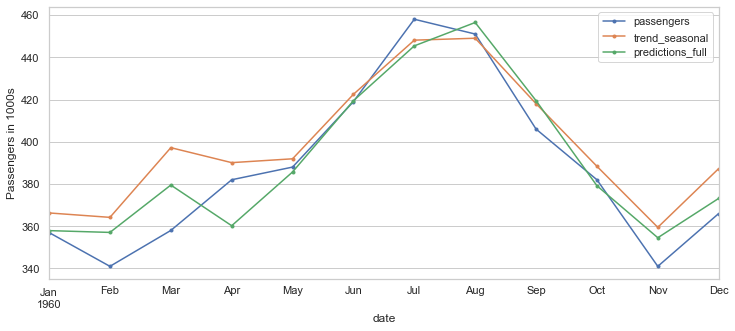

In [38]:
plot_timeseries(flights_test[['passengers', 'trend_seasonal', 'predictions_full']], ylim=False)

In [39]:
# let's check R squared score

print(r2_score(flights_test['passengers'], flights_test['trend_seasonal']))  # the score of the trend and season. model

print(r2_score(flights_test['passengers'], flights_test['predictions_full'])) # score of the full model

0.8036672855785705
0.8932731911942127


## 6. Generate short term predictions

## 6.1 Retrain my model on the whole data 

In [40]:
# join test and train data together

flights_combined = flights_train.append(flights_test)
flights_combined.tail()

,passengers,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,predictions_full
date,,,,,,,,,,,,,,,,,,
1960-08-01,451,139,0,1,0,0,0,0,0,0,0,0,0,0,449.013636,1.986364,9.895455,456.466478
1960-09-01,406,140,0,0,0,0,0,0,0,0,0,0,0,1,418.013636,-12.013636,1.986364,419.453666
1960-10-01,382,141,0,0,0,0,0,0,0,0,0,0,1,0,388.377273,-6.377273,-12.013636,379.173933
1960-11-01,341,142,0,0,0,0,0,0,0,0,0,1,0,0,359.468182,-18.468182,-6.377273,354.549835
1960-12-01,366,143,0,0,1,0,0,0,0,0,0,0,0,0,387.286364,-21.286364,-18.468182,373.176016


In [41]:
flights_combined.head()

,passengers,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,predictions_full
date,,,,,,,,,,,,,,,,,,
1949-02-01,75,1,0,0,0,1,0,0,0,0,0,0,0,0,57.503788,17.496212,4.405303,60.911282
1949-03-01,98,2,0,0,0,0,0,0,0,1,0,0,0,0,90.503788,7.496212,17.496212,103.863524
1949-04-01,93,3,1,0,0,0,0,0,0,0,0,0,0,0,83.412879,9.587121,7.496212,89.170208
1949-05-01,80,4,0,0,0,0,0,0,0,0,1,0,0,0,85.231061,-5.231061,9.587121,92.577984
1949-06-01,103,5,0,0,0,0,0,0,1,0,0,0,0,0,115.776515,-12.776515,-5.231061,111.858054


In [42]:
flights_combined.isna().sum()

passengers          0
timestep            0
April               0
August              0
December            0
February            0
January             0
July                0
June                0
March               0
May                 0
November            0
October             0
September           0
trend_seasonal      0
remainder           0
lag1                0
predictions_full    0
dtype: int64

In [43]:
# Re-train the model on the whole dataset
X_combined = flights_combined.drop(columns=['passengers', 'trend_seasonal', 'remainder', 'predictions_full'])
y_combined = flights_combined['passengers']

m_full_combined = LinearRegression()
m_full_combined.fit(X_combined, y_combined)

LinearRegression()

## 6.2 Generate prediction for a future time

In [44]:
flights_combined.index.max()

Timestamp('1960-12-01 00:00:00')

In [45]:
flights_combined.tail()

,passengers,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,predictions_full
date,,,,,,,,,,,,,,,,,,
1960-08-01,451,139,0,1,0,0,0,0,0,0,0,0,0,0,449.013636,1.986364,9.895455,456.466478
1960-09-01,406,140,0,0,0,0,0,0,0,0,0,0,0,1,418.013636,-12.013636,1.986364,419.453666
1960-10-01,382,141,0,0,0,0,0,0,0,0,0,0,1,0,388.377273,-6.377273,-12.013636,379.173933
1960-11-01,341,142,0,0,0,0,0,0,0,0,0,1,0,0,359.468182,-18.468182,-6.377273,354.549835
1960-12-01,366,143,0,0,1,0,0,0,0,0,0,0,0,0,387.286364,-21.286364,-18.468182,373.176016


In [61]:
# so we need to generate features for the time point 1961-01-01

X_future = []

timestep = flights_combined['timestep'].max() + 1
months = [0]*4 + [1] + [0]*7   #dummy code for Jan
lag = flights_combined.loc['1960-12-01', 'remainder'] # taking the last remainder 



In [47]:
X_future.append(timestep)
X_future.extend(months)
X_future.append(lag)



In [48]:
X_future

[144, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -21.286363636363717]

In [49]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

,timestep,April,August,December,February,January,July,June,March,May,November,October,September,lag1
0,144,0,0,0,0,1,0,0,0,0,0,0,0,-21.286364


In [60]:
print("Prediction for 1961-01-01 is {}".format(m_full_combined.predict(X_future)[0]))

Prediction for 1961-01-01 is 376.1058181519594


In [54]:
m_full_combined.coef_

array([  2.31152122,  -0.50341447,  46.93322197, -24.20732412,
       -24.91580663, -20.33394264,  49.82972461,  25.41964656,
         5.30840111,  -2.59087885, -50.23459561, -17.65423869,
        12.94920676,   0.74977923])